In [30]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/home/yuliya/repos/cosybio/FedProt/evaluation_utils/')
from evaluation import evaluation_func as fp_eval

from collections import OrderedDict

In [31]:
color_dict = OrderedDict()

color_dict["Methods"] = OrderedDict({
    "FedProt":"black",
    "Fisher":"#D44400",
    "Stouffer":"#E69F00",
    "REM":"#2E5EAA",
    "RankProd":"#009E73"
})

# Read results

In [32]:
dfs = {}

workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Bacterial dataset"] = df
print(f"Proteins: {len(df)}")


workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Human serum dataset"] = df
print(f"Proteins: {len(df)}")

Results loaded for DEqMS with 2831 proteins.
Results loaded for FedProt with 2831 proteins.
Results loaded for Fisher with 2824 proteins.
Results loaded for REM with 3023 proteins.
Results loaded for Stouffer with 2238 proteins.
Results loaded for RankProd with 3023 proteins.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results with 2238 genes. Adj.p-values were not log-transformed.
Results loaded for DEqMS with 532 proteins.
Results loaded for FedProt with 532 proteins.
Results loaded for Fisher with 432 proteins.
Results loaded for REM with 591 proteins.
Results loaded for Stouffer with 350 proteins.
Results loaded for RankProd with 591 proteins.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results with 350 genes. Adj.p-values were not log-transformed.


Proteins: 2238
Proteins: 350


In [33]:
log_dfs = {}
for k in dfs:
    df = dfs[k]
    df = df.replace(0,1e-300)
    df["pv_DEqMS"] = -np.log10(df["pv_DEqMS"])
    for m in ["FedProt", "Fisher","Stouffer","REM","RankProd"]:
        df["pv_"+m] = -np.log10(df["pv_"+m])
    log_dfs[k] = df

# Stats calculation

In [34]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

for dataset in log_dfs:

    pval_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset], 
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    logfc_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset],
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="lfc_",
        top_genes=-1
    )

    pval_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_pval_basic_stats.csv')
    logfc_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_logfc_basic_stats.csv')

    print(f'Dataset: {dataset}')
    print("\tLogFC basic stats:")
    print(logfc_basic_stats)
    print("\tP-value basic stats:")
    print(pval_basic_stats)        

Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
Correlations computed for all genes from lfc_ columns.
Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
Correlations computed for all genes from lfc_ columns.


Dataset: Bacterial dataset
	LogFC basic stats:
               MinDiff      MeanDiff       MaxDiff         r         ρ
FedProt   0.000000e+00  9.814980e-15  5.151435e-14  1.000000  1.000000
Fisher    8.950494e-07  5.749792e-03  1.935080e-01  0.999855  0.999728
Stouffer  8.950494e-07  5.749792e-03  1.935080e-01  0.999855  0.999728
REM       6.878582e-06  1.686182e-02  2.222525e-01  0.999317  0.997940
RankProd  8.950494e-07  5.749792e-03  1.935080e-01  0.999855  0.999728
	P-value basic stats:
           MinDiff      MeanDiff       MaxDiff         r         ρ
FedProt   0.000000  4.426169e-13  3.455014e-12  1.000000  1.000000
Fisher    0.001837  4.003183e+00  2.678062e+01  0.981028  0.955488
Stouffer  0.004098  3.443773e+00  2.499144e+01  0.988485  0.963245
REM       0.000050  1.571957e+01  2.626194e+02  0.763115  0.909137
RankProd  0.000368  1.425206e+01  8.368133e+01  0.774922  0.857192
Dataset: Human serum dataset
	LogFC basic stats:
           MinDiff      MeanDiff       MaxDiff        

In [28]:
# shorter version of log_dfs taking only 50% of rows randomly
short_log_dfs = {}
for dataset in log_dfs:
    if dataset == "Bacterial dataset":
        short_log_dfs[dataset] = log_dfs[dataset].sample(frac=0.25, random_state=1)
    else:
        short_log_dfs[dataset] = log_dfs[dataset].sample(frac=0.75, random_state=1)
    print(f"Dataset: {dataset}, proteins: {len(short_log_dfs[dataset])}")

Dataset: Bacterial dataset, proteins: 560
Dataset: Human serum dataset, proteins: 262


Plotting corrs using p-vals - log-transformed.


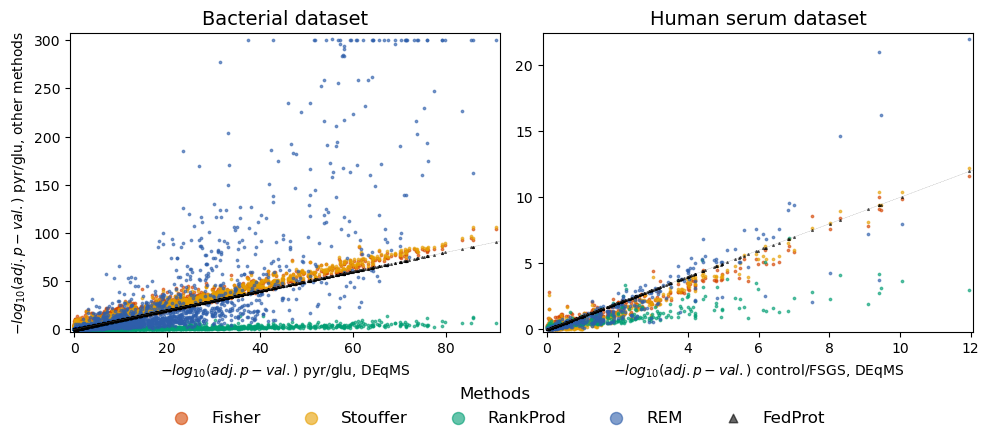

In [29]:
plot_one = fp_eval.plt_results(
    log_dfs, 
    methods=["Fisher", "Stouffer", "RankProd", "REM", "FedProt"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=3,
    datasets=list(log_dfs.keys()),
    figsize=(10,4),
    add_table=False,
    sharex=False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using logFC values.


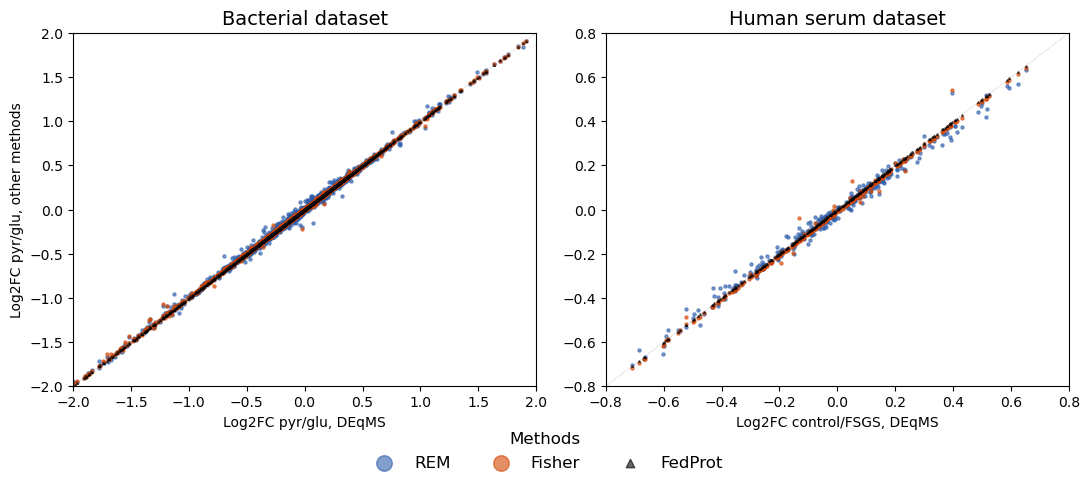

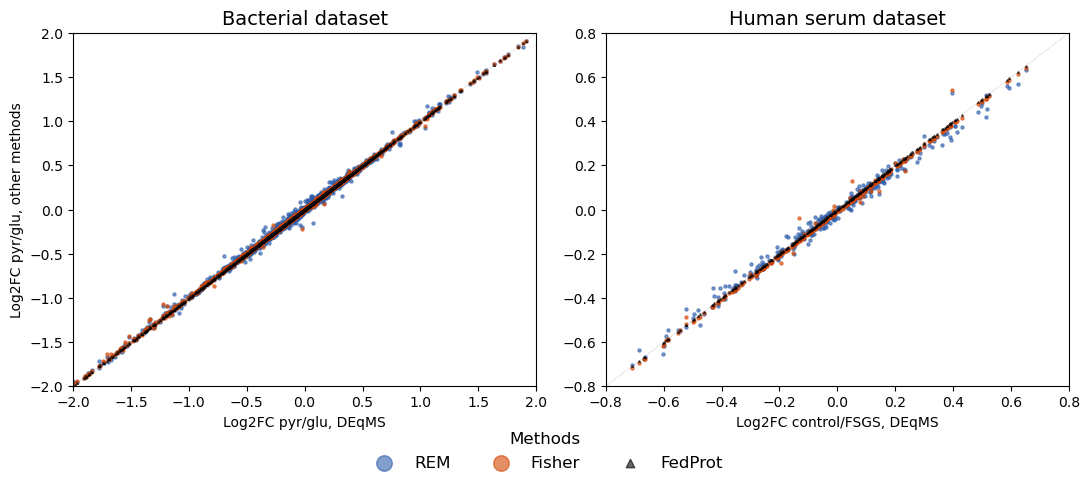

In [8]:
fp_eval.plt_results(
    log_dfs, 
    methods=["REM", "Fisher", "FedProt"],
    color_dict=color_dict,
    what="lfc_", 
    text="", dotsize=5,
    datasets=list(log_dfs.keys()),
    add_table=False,
    sharex =False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"],
    set_lims = [[-2,2], [-0.8, 0.8]]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

In [17]:
# how many values are above 1.7 or below -1.7 for bacterial dataset
for dataset in log_dfs:
    df = log_dfs[dataset]
    number = 2 if dataset == "Bacterial dataset" else 0.8
    print(f"Dataset: {dataset}")
    for method in ["DEqMS", "FedProt", "Fisher", "Stouffer", "REM", "RankProd"]:
        print(f"\tMethod: {method}")
        print(f"\t\tValues [> {number} or < -{number}]: {len(df[(df['lfc_'+method] > number) | (df['lfc_'+method] < -1 * number)])}")
        # % out of all proteins
        print(f"\t\t% of values : {len(df[(df['lfc_'+method] > number) | (df['lfc_'+method] < -1 * number)])/len(df)*100:.2f}%")

Dataset: Bacterial dataset
	Method: DEqMS
		Values [> 2 or < -2]: 67
		% of values : 2.99%
	Method: FedProt
		Values [> 2 or < -2]: 67
		% of values : 2.99%
	Method: Fisher
		Values [> 2 or < -2]: 67
		% of values : 2.99%
	Method: Stouffer
		Values [> 2 or < -2]: 67
		% of values : 2.99%
	Method: REM
		Values [> 2 or < -2]: 64
		% of values : 2.86%
	Method: RankProd
		Values [> 2 or < -2]: 67
		% of values : 2.99%
Dataset: Human serum dataset
	Method: DEqMS
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%
	Method: FedProt
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%
	Method: Fisher
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%
	Method: Stouffer
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%
	Method: REM
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%
	Method: RankProd
		Values [> 0.8 or < -0.8]: 3
		% of values : 0.86%


# average expression - methods results

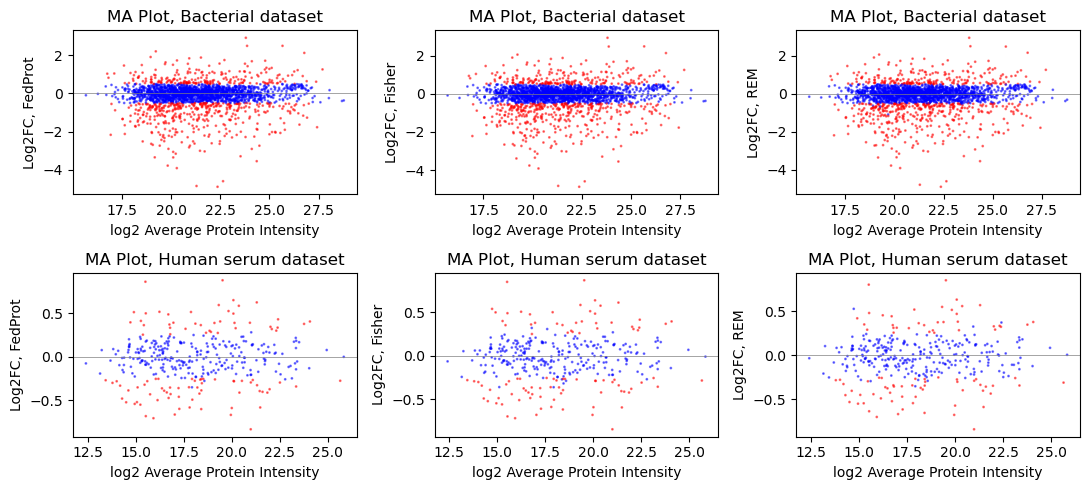

In [11]:
fp_eval.plot_ma_plots(
    log_dfs, 
    what="lfc_", 
    methods=["FedProt", "Fisher", "REM"],
    lfc_thr=[0.5, 0.25], 
    adj_pval_thr=[0.05, 0.05],
    figsize=(11, 5)
)

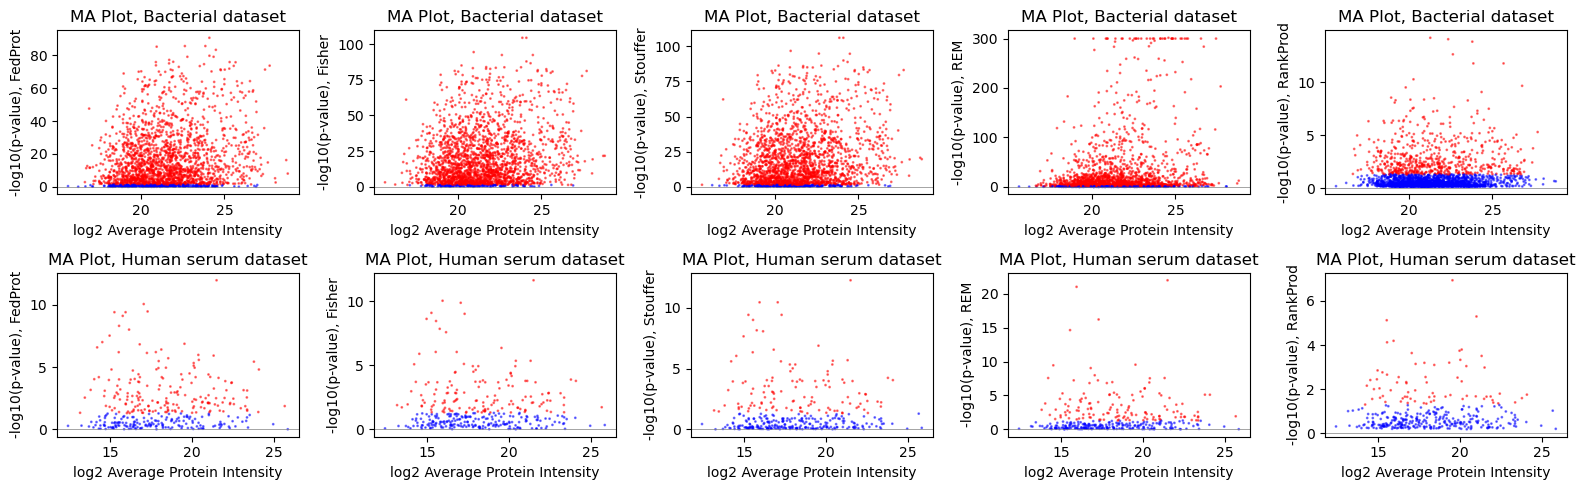

In [12]:
fp_eval.plot_ma_plots(
    log_dfs, 
    what="pv_", 
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    lfc_thr=[0.5, 0.25], 
    adj_pval_thr=[0.05, 0.05],
    figsize=(16, 5)
)

# Top lists

In [9]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

fp_fn_b = fp_eval.calc_stats(
    log_dfs["Bacterial dataset"], 
    lfc_thr=0.5, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_h = fp_eval.calc_stats(
    log_dfs["Human serum dataset"], 
    lfc_thr=0.25, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_b.to_csv(f'{root_dir}/tables/Bacterial_FP_FN.csv')
fp_fn_h.to_csv(f'{root_dir}/tables/Human_FP_FN.csv')

print("\tFP/FN bacterial dataset:")
print(fp_fn_b)  
print("\tFP/FN human serum dataset:")
print(fp_fn_h)

Performance metrics calculated for all genes.
Performance metrics calculated for all genes.


	FP/FN bacterial dataset:
           FP     FN   Jaccard
FedProt   0.0    0.0  1.000000
Fisher    3.0    4.0  0.988411
Stouffer  3.0    4.0  0.988411
REM       8.0   15.0  0.962233
RankProd  1.0  111.0  0.813953
	FP/FN human serum dataset:
           FP    FN   Jaccard
FedProt   0.0   0.0  1.000000
Fisher    2.0   6.0  0.922330
Stouffer  2.0  13.0  0.854369
REM       1.0  13.0  0.862745
RankProd  1.0  33.0  0.666667


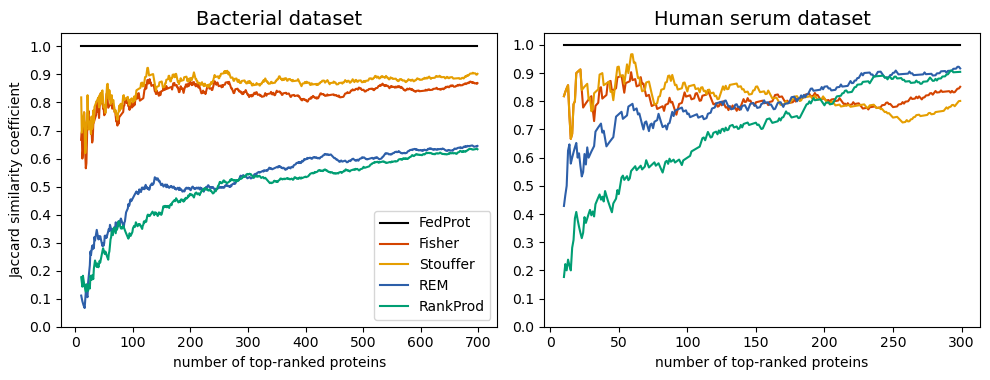

In [10]:
min_n_genes = 10
step = 1

data, plot_two = fp_eval.plot_stats_for_topN(
    log_dfs,
    datasets = list(log_dfs.keys()),
    methods=["FedProt", "Fisher","Stouffer","REM", "RankProd"],
    metrics=["Jaccard"],
    min_n_genes=min_n_genes,
    max_n_genes=[700, 300],
    figsize=(10,3.9),
    step=step,
    color_dict=color_dict,
    sharey=False,
    )

In [14]:
print(f"All data: {log_dfs['Bacterial dataset'].shape[0]}")
# filtet DE genes based on DEqMS
print(f"DE proteins: {log_dfs['Bacterial dataset'][(log_dfs['Bacterial dataset']['pv_DEqMS'] > -np.log(0.05)) & (np.abs(log_dfs['Bacterial dataset']['lfc_DEqMS']) > 0.5)].shape[0]}")

All data: 2238
DE proteins: 601


In [15]:
print(f"All data: {log_dfs['Human serum dataset'].shape[0]}")
# filtet DE genes based on DEqMS
print(f"DE proteins: {log_dfs['Human serum dataset'][(log_dfs['Human serum dataset']['pv_DEqMS'] > -np.log(0.05)) & (np.abs(log_dfs['Human serum dataset']['lfc_DEqMS']) > 0.25)].shape[0]}")

All data: 350
DE proteins: 64
